In [1]:
# Imports 
import numpy as np
from icnn_tf import Agent
from agent import *
import evaluation
import importlib
import tensorflow as tf
import tflearn
import matplotlib.pyplot as plt
import gym
import actor_critic_mountaincar as ac
flags = tf.app.flags
FLAGS = flags.FLAGS
%matplotlib inline

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


## Importing our MountainCar trained agents

In [2]:
# Creating agent and filling it with an imported version
beta0 = .9
max_steps_beta = int(5e4)
beta = lambda t: (t<max_steps_beta)*(beta0 + t*(1-beta0)/max_steps_beta) + (t>=max_steps_beta)*1.
agent = Agent(2,1,beta,[20,20],finalize_graph=False)
agent.restore('tensorboard/models/38314')
tflearn.is_training(False, session=agent.sess)

# agent2 = Agent(2,1,beta,[20,20],finalize_graph=False)
# agent2.restore('tensorboard/models/32314')
# tflearn.is_training(False, session=agent2.sess)

x shape (?, 2)
y shape (?, 1)
z shape (?, 1)
x shape (?, 2)
y shape (?, 1)
z shape (?, 1)
y shape (?,)
q shape (?,)
per weights shape (?,)
multi td error^2 per weights shape (?,)
ms td error shape ()
INFO:tensorflow:Summary name Qvalue (batch avg) is illegal; using Qvalue__batch_avg_ instead.
INFO:tensorflow:Summary name Qvalue (batch max) is illegal; using Qvalue__batch_max_ instead.
INFO:tensorflow:Summary name Qvalue (batch min) is illegal; using Qvalue__batch_min_ instead.
INFO:tensorflow:Summary name Q targets (batch avg) is illegal; using Q_targets__batch_avg_ instead.
INFO:tensorflow:Summary name Q targets (batch min) is illegal; using Q_targets__batch_min_ instead.
INFO:tensorflow:Summary name Q targets (batch max) is illegal; using Q_targets__batch_max_ instead.
INFO:tensorflow:Summary name td error is illegal; using td_error instead.
INFO:tensorflow:Summary name chosen actions is illegal; using chosen_actions instead.
INFO:tensorflow:Summary name maximizing action (batch avg)

## Getting histories with winning MountainCar implementation

In [24]:
importlib.reload(ac)

policy_lr, value_lr, lamb, gamma = [0.0001, 0.00046415888336127773, 2.782559402207126e-05, 0.98999999999999999]
loss, histories, policy_estimator, value_estimator, sess = ac.actor_critic(episodes=50, gamma=gamma, display=False, lamb=lamb, policy_lr=policy_lr, value_lr=value_lr)
print('len(histories)',len(histories))
print('len(histories[0])',len(histories[0]))
print('-loss',-loss)
# print('histories[0]',histories[0])
print('Action prediction for initial state:',policy_estimator.predict([-0.4,0],sess))
print('Value prediction for initial state:',value_estimator.predict([-0.4,0],sess))

Episode: 0, reward: 80.44633561973214, length: 635
Episode: 1, reward: -28.088110074941905, length: 999
Episode: 2, reward: 86.30179464506926, length: 594
Episode: 3, reward: -26.197427198762345, length: 999
Episode: 4, reward: 89.50172337149318, length: 466
Episode: 5, reward: 87.19413061831908, length: 604
Episode: 6, reward: -24.621898806322132, length: 999
Episode: 7, reward: -22.644811235172913, length: 999
Episode: 8, reward: 80.17897705690106, length: 767
Episode: 9, reward: 92.59810255600664, length: 429
Episode: 10, reward: 92.59388728042238, length: 452
Episode: 11, reward: -20.324356291216542, length: 999
Episode: 12, reward: -21.641796165324287, length: 999
Episode: 13, reward: 84.93909641035397, length: 816
Episode: 14, reward: 92.03048076059541, length: 555
Episode: 15, reward: 83.57784233862566, length: 828
Episode: 16, reward: 92.14983386365437, length: 437
Episode: 17, reward: 94.48493893019754, length: 334
Episode: 18, reward: 85.87063300933322, length: 725
Episode: 1

<class 'numpy.ndarray'>


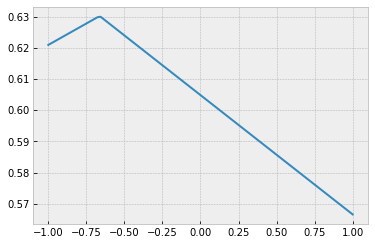

In [7]:
# Plotting the action to check validity
action_steps =100
action_range = np.linspace(-1,1,action_steps).reshape((action_steps,1))
state_range = np.array([[-0.4,0.4]]*action_steps)
Q_values_action_sweep = -agent._fg(state_range,action_range)[0]
print(type(Q_values_action_sweep))
plt.plot(action_range, Q_values_action_sweep)
plt.show()

In [25]:
def train_episode_mountaincar(agent, env, max_iter):
    global_step = -1
    max_steps_beta = 100000
    beta0 = .9
    beta = lambda t: (t<max_steps_beta)*(beta0 + t*(1-beta0)/max_steps_beta) + (t>=max_steps_beta)*1.
    all_rewards = [0]
    history = []

    RMIN, RMAX = -1, 100

    ss = env.reset()
    it=0
    while it< max_iter:
        global_step += 1

        # act
        agent.observation = ss
        a = agent.act()
        ss_, reward, done, info = env.step(a)
        reward *= (reward>0)
        all_rewards.append(all_rewards[-1]+reward)
        agent.rm.add(*(ss, a, reward, ss_, np.array([done])))
        history.append([ss, a, reward, ss_])
        ss = ss_
        
        loss, td_error, q_entr, q_target = agent.train()   
#         env.render()
        it+=1
        if done:
            ss = env.reset()
            return history, agent
    
    return history, agent

def Q_func(s,a):
    if s.shape == (2,):
        s=s.reshape(1,2)
    if a.shape == (1,):
        a=a.reshape(1,1)
        
    return -agent._fg(s,a)[0]

def Q_func_b(s,a):
    params  = policy_estimator.get_q_function_params(s, sess)
#     print(params)
    mu = params[0]
    sig = params[1]
    
    return (1/(sig*np.sqrt(2*np.pi)))*np.exp(-(a - mu)**2 / (2 * sig**2))

def generate_histories_mountaincar(n_histories, agent, env):
    cont_states_sequence = []
    cont_actions_sequence = []
    rewards_sequence = []
    fence_posts = [0]*(n_histories+1)

    for h in range(n_histories):
        history, agent = train_episode_mountaincar(agent, env, 300)
        cont_states_sequence.extend([hi[0] for hi in history])
        cont_actions_sequence.extend([hi[1] for hi in history])
        rewards_sequence.extend([hi[2] for hi in history])
        fence_posts[h+1]=(fence_posts[h]+len(history))
        print("history",h,"is of length:",len(history))
    
    return np.array(cont_states_sequence), np.array(cont_actions_sequence), np.array(rewards_sequence), fence_posts[1:-1], agent

def get_variables_for_WDR(histories_dict):
    
    cont_states_sequence = []
    cont_actions_sequence = []
    rewards_sequence = []
    fence_posts = [0]*(len(histories_dict)+1)
    i=0
    for k in histories_dict.keys():
        cont_states_sequence.extend(h[0] for h in histories_dict[k])
        cont_actions_sequence.extend(h[1] for h in histories_dict[k])
        rewards_sequence.extend(h[2] for h in histories_dict[k])
        fence_posts[i+1]=(fence_posts[i]+len(histories_dict[k]))
        i+=1
    return np.array(cont_states_sequence), np.array(cont_actions_sequence), np.array(rewards_sequence), fence_posts[1:-1], agent


# env = gym.make('MountainCarContinuous-v0')
# env.reset()
gamma = .99
extremums_of_action_space = (-1, 1)
cont_states_sequence, cont_actions_sequence, rewards_sequence, fence_posts, agent =get_variables_for_WDR(histories)
pi_evaluation = Q_func
pi_behavior = Q_func_b

print('cont_states_sequence.shape',cont_states_sequence.shape)
print('cont_actions_sequence.shape',cont_actions_sequence.shape)
print('rewards_sequence.shape',rewards_sequence.shape)
print('fence_posts:', fence_posts)

cont_states_sequence.shape (28842, 2)
cont_actions_sequence.shape (28842, 1)
rewards_sequence.shape (28842,)
fence_posts: [635, 1634, 2228, 3227, 3693, 4297, 5296, 6295, 7062, 7491, 7943, 8942, 9941, 10757, 11312, 12140, 12577, 12911, 13636, 13987, 14465, 14914, 15464, 15982, 16613, 17033, 17949, 18287, 18712, 19077, 19504, 20026, 20452, 20942, 21393, 21778, 22316, 22690, 23461, 23952, 24740, 25231, 25795, 26060, 26551, 26894, 27312, 28125, 28491]


In [26]:
importlib.reload(evaluation)

# print(pi_behavior(cont_states_sequence, cont_actions_sequence))

WDR_estim, indiv_estim = evaluation.eval_ICNN_WDR_mountaincar(pi_evaluation, pi_behavior, extremums_of_action_space, 
                                                                cont_states_sequence, cont_actions_sequence, 
                                                                rewards_sequence, fence_posts, gamma)

print('WDR_estim:',WDR_estim)

Starting WDR calculations
Starting calculation of individual estimators (per episode)


  0%|          | 0/49 [00:00<?, ?it/s]

Estimator for episode 0 : [-0.02692792]


  2%|▏         | 1/49 [00:19<15:23, 19.24s/it]

Estimator for episode 1 : [-0.79787569]


  4%|▍         | 2/49 [00:30<13:14, 16.90s/it]

Estimator for episode 2 : [ 0.00952076]


  6%|▌         | 3/49 [00:49<13:27, 17.55s/it]

Estimator for episode 3 : [-0.09922989]


  8%|▊         | 4/49 [00:58<11:14, 14.99s/it]

Estimator for episode 4 : [-0.69515552]


 10%|█         | 5/49 [01:10<10:10, 13.88s/it]

Estimator for episode 5 : [ 0.00285961]


 12%|█▏        | 6/49 [01:29<11:06, 15.50s/it]

Estimator for episode 6 : [ 0.01072835]


 14%|█▍        | 7/49 [01:49<11:45, 16.79s/it]

Estimator for episode 7 : [-0.0041179]


 16%|█▋        | 8/49 [02:03<10:59, 16.09s/it]

Estimator for episode 8 : [-0.00331174]


 18%|█▊        | 9/49 [02:11<09:07, 13.68s/it]

Estimator for episode 9 : [ 0.01012587]


 20%|██        | 10/49 [02:19<07:50, 12.08s/it]

Estimator for episode 10 : [ 0.00737245]


 22%|██▏       | 11/49 [02:39<09:01, 14.25s/it]

Estimator for episode 11 : [-0.00607337]


 24%|██▍       | 12/49 [02:59<09:50, 15.96s/it]

Estimator for episode 12 : [ 0.00965759]


 27%|██▋       | 13/49 [03:15<09:38, 16.07s/it]

Estimator for episode 13 : [ 0.00974896]


 29%|██▊       | 14/49 [03:26<08:23, 14.38s/it]

Estimator for episode 14 : [ 0.01026483]


 31%|███       | 15/49 [03:42<08:33, 15.11s/it]

Estimator for episode 15 : [ 0.0096358]


 33%|███▎      | 16/49 [03:50<07:09, 13.00s/it]

Estimator for episode 16 : [ 0.002317]


 35%|███▍      | 17/49 [03:57<05:50, 10.96s/it]

Estimator for episode 17 : [ 0.00997676]


 37%|███▋      | 18/49 [04:11<06:13, 12.03s/it]

Estimator for episode 18 : [ 0.0017071]


 39%|███▉      | 19/49 [04:18<05:15, 10.52s/it]

Estimator for episode 19 : [ 0.00813669]


 41%|████      | 20/49 [04:28<04:58, 10.30s/it]

Estimator for episode 20 : [ 0.00740485]


 43%|████▎     | 21/49 [04:37<04:35,  9.82s/it]

Estimator for episode 21 : [ 0.00934728]


 45%|████▍     | 22/49 [04:47<04:29,  9.99s/it]

Estimator for episode 22 : [ 0.0094397]


 47%|████▋     | 23/49 [04:58<04:24, 10.18s/it]

Estimator for episode 23 : [ 0.00939524]


 49%|████▉     | 24/49 [05:09<04:26, 10.65s/it]

Estimator for episode 24 : [ 0.00836705]


 51%|█████     | 25/49 [05:17<03:54,  9.77s/it]

Estimator for episode 25 : [ 0.00813449]


 53%|█████▎    | 26/49 [05:52<06:38, 17.34s/it]

Estimator for episode 26 : [-0.02461952]


 55%|█████▌    | 27/49 [06:00<05:22, 14.64s/it]

Estimator for episode 27 : [ 0.00965425]


 57%|█████▋    | 28/49 [06:09<04:31, 12.91s/it]

Estimator for episode 28 : [ 0.00944903]


 59%|█████▉    | 29/49 [06:16<03:43, 11.15s/it]

Estimator for episode 29 : [ 0.008299]


 61%|██████    | 30/49 [06:25<03:16, 10.34s/it]

Estimator for episode 30 : [ 0.00025263]


 63%|██████▎   | 31/49 [06:35<03:05, 10.32s/it]

Estimator for episode 31 : [ 0.00974788]


 65%|██████▌   | 32/49 [06:44<02:46,  9.82s/it]

Estimator for episode 32 : [ 0.00980597]


 67%|██████▋   | 33/49 [06:53<02:35,  9.70s/it]

Estimator for episode 33 : [ 0.0098943]


 69%|██████▉   | 34/49 [07:02<02:21,  9.40s/it]

Estimator for episode 34 : [ 0.01008098]


 71%|███████▏  | 35/49 [07:09<02:01,  8.71s/it]

Estimator for episode 35 : [-0.00105387]


 73%|███████▎  | 36/49 [07:19<01:58,  9.11s/it]

Estimator for episode 36 : [ 0.01009523]


 76%|███████▌  | 37/49 [07:26<01:42,  8.57s/it]

Estimator for episode 37 : [ 0.00757183]


 78%|███████▊  | 38/49 [07:41<01:52, 10.26s/it]

Estimator for episode 38 : [-0.0771072]


 80%|███████▉  | 39/49 [07:50<01:41, 10.16s/it]

Estimator for episode 39 : [-0.0158309]


 82%|████████▏ | 40/49 [08:07<01:48, 12.08s/it]

Estimator for episode 40 : [ 0.01019871]


 84%|████████▎ | 41/49 [08:17<01:31, 11.41s/it]

Estimator for episode 41 : [ 0.00791139]


 86%|████████▌ | 42/49 [08:27<01:18, 11.15s/it]

Estimator for episode 42 : [ 0.00445297]


 88%|████████▊ | 43/49 [08:33<00:56,  9.48s/it]

Estimator for episode 43 : [ 0.01022289]


 90%|████████▉ | 44/49 [08:43<00:47,  9.54s/it]

Estimator for episode 44 : [ 0.00898687]


 92%|█████████▏| 45/49 [08:49<00:34,  8.64s/it]

Estimator for episode 45 : [-0.00299714]


 94%|█████████▍| 46/49 [08:58<00:25,  8.58s/it]

Estimator for episode 46 : [ 0.0017264]


 96%|█████████▌| 47/49 [09:14<00:22, 11.04s/it]

Estimator for episode 47 : [ 0.00794624]


 98%|█████████▊| 48/49 [09:22<00:09,  9.99s/it]

Estimator for episode 48 : [ 0.00861101]


100%|██████████| 49/49 [09:29<00:00,  9.19s/it]


Time elapsed in WDR calculation: 646.205081831014
WDR_estim: -1.45525275097


In [27]:
print('Value_estimation for initial state [-0.4, 0]:',value_estimator.predict([-0.4, 0],sess))

Value_estimation for initial state [-0.4, 0]: -2.00868
